# How Activation Functions Enable Non-Linear Approximation

## 🎯 The Fundamental Question

**Question**: If forward propagation is just:
```
((X·W1 + b1)·W2 + b2)·W3 + b3 = X·(W1·W2·W3) + constants
```

This simplifies to `X·W_combined + b_combined` → **Still linear!**

**So how can a neural network learn quadratic functions like y = x²?**

---

## 📋 What This Notebook Demonstrates

1. **The Problem**: Why linear networks collapse to a single layer
2. **The Solution**: How activation functions prevent this collapse
3. **Mathematical Proof**: Why activation functions enable non-linearity
4. **Visual Demonstrations**: See the difference in action
5. **Universal Approximation**: How networks can learn any function

Let's dive in! 🚀

## 1. Setup and Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## 2. The Problem: Linear Networks Collapse

### Mathematical Proof

Consider a 2-layer network **WITHOUT** activation functions:

```
Layer 1: h1 = X·W1 + b1
Layer 2: h2 = h1·W2 + b2
Output:  y = h2·W3 + b3
```

Substituting:
```
h2 = (X·W1 + b1)·W2 + b2
   = X·W1·W2 + b1·W2 + b2

y = (X·W1·W2 + b1·W2 + b2)·W3 + b3
  = X·(W1·W2·W3) + (b1·W2·W3 + b2·W3 + b3)
  = X·W_combined + b_combined
```

**Result**: Still linear! Multiple layers = waste of computation! ❌

In [28]:
# Generate data: y = x²
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y_true = X ** 2

# Add some noise
y_noisy = y_true + np.random.normal(0, 0.1, y_true.shape)

print(f"Generated {len(X)} data points for y = x²")
print(f"X range: [{X.min():.2f}, {X.max():.2f}]")
print(f"y range: [{y_true.min():.2f}, {y_true.max():.2f}]")

Generated 100 data points for y = x²
X range: [-3.00, 3.00]
y range: [0.00, 9.00]


### Demo 1: Linear Network (No Activations)

In [29]:
class LinearNetwork:
    """Network WITHOUT activation functions"""
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
        # Initialize weights
        self.W1 = np.random.randn(1, 1) * 0.1
        self.b1 = np.zeros((1, 1))
        self.W2 = np.random.randn(1, 1) * 0.1
        self.b2 = np.zeros((1, 1))
        self.W3 = np.random.randn(1, 1) * 0.1
        self.b3 = np.zeros((1, 1))
        
    def forward(self, X):
        # NO ACTIVATION FUNCTIONS!
        self.h1 = X @ self.W1 + self.b1
        self.h2 = self.h1 @ self.W2 + self.b2
        self.y_pred = self.h2 @ self.W3 + self.b3
        self.X = X
        return self.y_pred
    
    def backward(self, y_true, y_pred):
        n = len(y_true)
        # Compute gradients
        dL_dy = 2 * (y_pred - y_true) / n
        
        dL_dW3 = self.h2.T @ dL_dy
        dL_db3 = np.sum(dL_dy, axis=0, keepdims=True)
        
        dL_dh2 = dL_dy @ self.W3.T
        dL_dW2 = self.h1.T @ dL_dh2
        dL_db2 = np.sum(dL_dh2, axis=0, keepdims=True)
        
        dL_dh1 = dL_dh2 @ self.W2.T
        dL_dW1 = self.X.T @ dL_dh1
        dL_db1 = np.sum(dL_dh1, axis=0, keepdims=True)
        
        # Update weights
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
    
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

# Train linear network
linear_net = LinearNetwork(learning_rate=0.01)
linear_losses = []

for epoch in range(1000):
    y_pred = linear_net.forward(X)
    loss = linear_net.compute_loss(y_noisy, y_pred)
    linear_net.backward(y_noisy, y_pred)
    linear_losses.append(loss)

print(f"✅ Linear network trained for 1000 epochs")
print(f"Final loss: {linear_losses[-1]:.4f}")

✅ Linear network trained for 1000 epochs
Final loss: 7.5303


### Demo 2: Non-Linear Network (With tanh Activations)

In [30]:
class NonLinearNetwork:
    """Network WITH activation functions"""
    def __init__(self, learning_rate=0.01, hidden_size=1):
        self.lr = learning_rate
        # Initialize weights with Xavier/Glorot initialization for better training
        self.W1 = np.random.randn(1, hidden_size) * np.sqrt(2.0 / 1)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, 1) * np.sqrt(2.0 / hidden_size)
        self.b3 = np.zeros((1, 1))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2
    
    def forward(self, X):
        # WITH ACTIVATION FUNCTIONS!
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.tanh(self.z1)  # ← Activation!
        
        self.z2 = self.h1 @ self.W2 + self.b2
        self.h2 = self.tanh(self.z2)  # ← Activation!
        
        self.y_pred = self.h2 @ self.W3 + self.b3
        self.X = X
        return self.y_pred
    
    def backward(self, y_true, y_pred):
        n = len(y_true)
        dL_dy = 2 * (y_pred - y_true) / n
        
        dL_dW3 = self.h2.T @ dL_dy
        dL_db3 = np.sum(dL_dy, axis=0, keepdims=True)
        
        dL_dh2 = dL_dy @ self.W3.T
        dL_dz2 = dL_dh2 * self.tanh_derivative(self.z2)
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.tanh_derivative(self.z1)
        dL_dW1 = self.X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
    
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

# Train non-linear network with more neurons
nonlinear_net = NonLinearNetwork(learning_rate=0.01, hidden_size=10)
nonlinear_losses = []

for epoch in range(1000):
    y_pred = nonlinear_net.forward(X)
    loss = nonlinear_net.compute_loss(y_noisy, y_pred)
    nonlinear_net.backward(y_noisy, y_pred)
    nonlinear_losses.append(loss)

print(f"✅ Non-linear network trained for 1000 epochs")
print(f"Final loss: {nonlinear_losses[-1]:.4f}")

✅ Non-linear network trained for 1000 epochs
Final loss: 0.0349


## 3. Visual Comparison: The Dramatic Difference

/tmp/ipython-input-2275284323.py:42: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2275284323.py:42: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2275284323.py:43: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.savefig('linear_vs_nonlinear_comparison.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2275284323.py:43: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.savefig('linear_vs_nonlinear_comparison.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAV

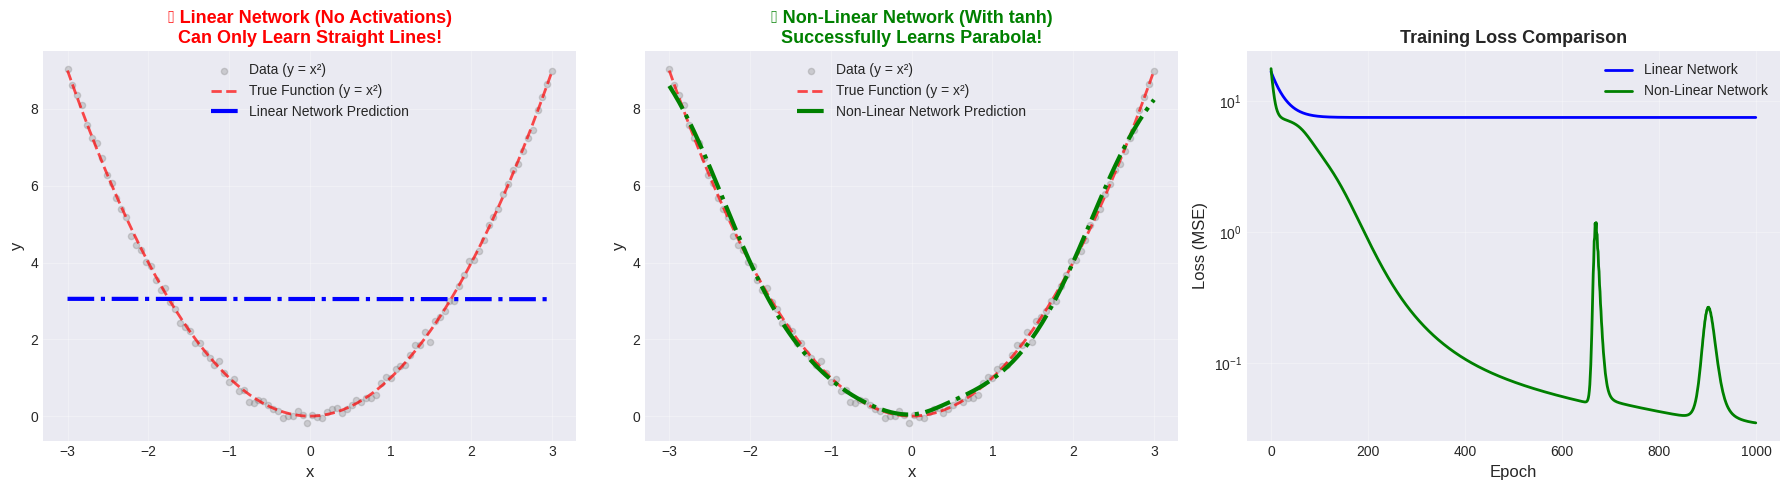


📊 Results:
  Linear Network Final Loss: 7.5303
  Non-Linear Network Final Loss: 0.0349
  Improvement: 216.0x better!


In [31]:
# Generate predictions
X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
y_linear = linear_net.forward(X_plot)
y_nonlinear = nonlinear_net.forward(X_plot)
y_true_plot = X_plot ** 2

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Linear Network Result
axes[0].scatter(X, y_noisy, alpha=0.3, s=20, label='Data (y = x²)', color='gray')
axes[0].plot(X_plot, y_true_plot, 'r--', linewidth=2, label='True Function (y = x²)', alpha=0.7)
axes[0].plot(X_plot, y_linear, 'b-.', linewidth=3, label='Linear Network Prediction')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('❌ Linear Network (No Activations)\nCan Only Learn Straight Lines!', 
                  fontsize=13, fontweight='bold', color='red')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Non-Linear Network Result
axes[1].scatter(X, y_noisy, alpha=0.3, s=20, label='Data (y = x²)', color='gray')
axes[1].plot(X_plot, y_true_plot, 'r--', linewidth=2, label='True Function (y = x²)', alpha=0.7)
axes[1].plot(X_plot, y_nonlinear, 'g-.', linewidth=3, label='Non-Linear Network Prediction')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('✅ Non-Linear Network (With tanh)\nSuccessfully Learns Parabola!', 
                  fontsize=13, fontweight='bold', color='green')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Training Loss Comparison
axes[2].plot(linear_losses, label='Linear Network', linewidth=2, color='blue')
axes[2].plot(nonlinear_losses, label='Non-Linear Network', linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Loss (MSE)', fontsize=12)
axes[2].set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
axes[2].set_yscale('log')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('linear_vs_nonlinear_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Results:")
print(f"  Linear Network Final Loss: {linear_losses[-1]:.4f}")
print(f"  Non-Linear Network Final Loss: {nonlinear_losses[-1]:.4f}")
print(f"  Improvement: {(linear_losses[-1] / nonlinear_losses[-1]):.1f}x better!")

## 4. Understanding Activation Functions

### The tanh Function

The hyperbolic tangent function is defined as:

$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

**Key Properties:**
- Range: (-1, 1)
- Zero-centered: tanh(0) = 0
- Smooth and differentiable
- Derivative: $\tanh'(x) = 1 - \tanh^2(x)$

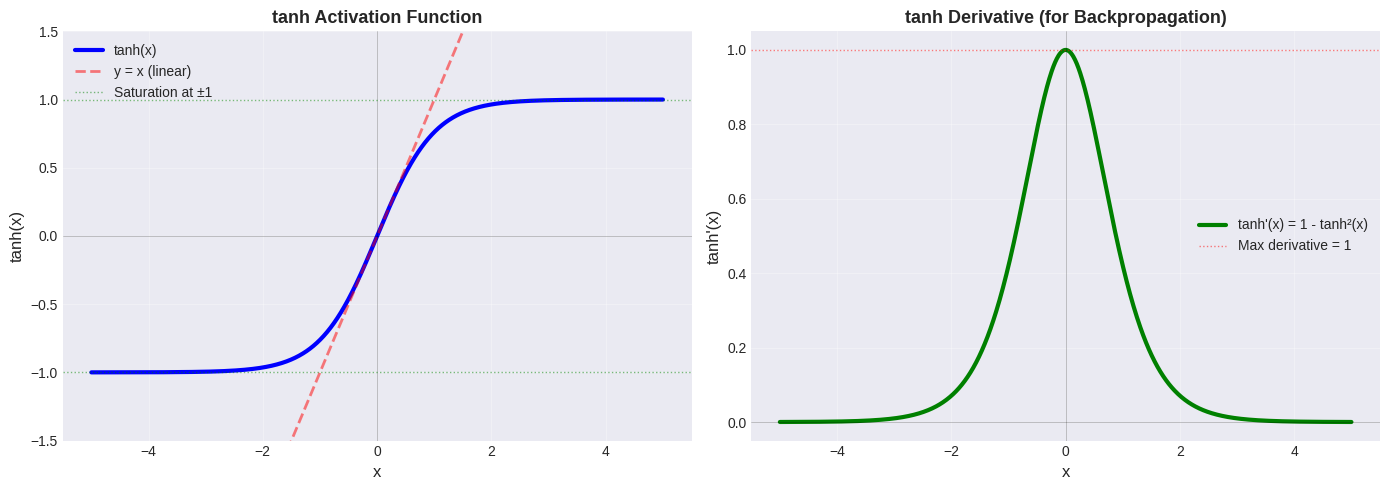


📐 tanh Properties:
  tanh(0) = 0.0000
  tanh(1) = 0.7616
  tanh(5) = 0.9999 (saturated)
  tanh'(0) = 1.0000 (maximum gradient)


In [32]:
# Visualize tanh and its derivative
x = np.linspace(-5, 5, 1000)
tanh_x = np.tanh(x)
tanh_derivative = 1 - np.tanh(x) ** 2

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot tanh function
axes[0].plot(x, tanh_x, 'b-', linewidth=3, label='tanh(x)')
axes[0].plot(x, x, 'r--', linewidth=2, alpha=0.5, label='y = x (linear)')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].axhline(y=1, color='g', linestyle=':', linewidth=1, alpha=0.5, label='Saturation at ±1')
axes[0].axhline(y=-1, color='g', linestyle=':', linewidth=1, alpha=0.5)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('tanh(x)', fontsize=12)
axes[0].set_title('tanh Activation Function', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1.5, 1.5)

# Plot tanh derivative
axes[1].plot(x, tanh_derivative, 'g-', linewidth=3, label="tanh'(x) = 1 - tanh²(x)")
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].axhline(y=1, color='r', linestyle=':', linewidth=1, alpha=0.5, label='Max derivative = 1')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel("tanh'(x)", fontsize=12)
axes[1].set_title('tanh Derivative (for Backpropagation)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tanh_function_and_derivative.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📐 tanh Properties:")
print(f"  tanh(0) = {np.tanh(0):.4f}")
print(f"  tanh(1) = {np.tanh(1):.4f}")
print(f"  tanh(5) = {np.tanh(5):.4f} (saturated)")
print(f"  tanh'(0) = {1 - np.tanh(0)**2:.4f} (maximum gradient)")

## 5. Layer-by-Layer Transformation

Let's visualize what each layer does to the input signal.

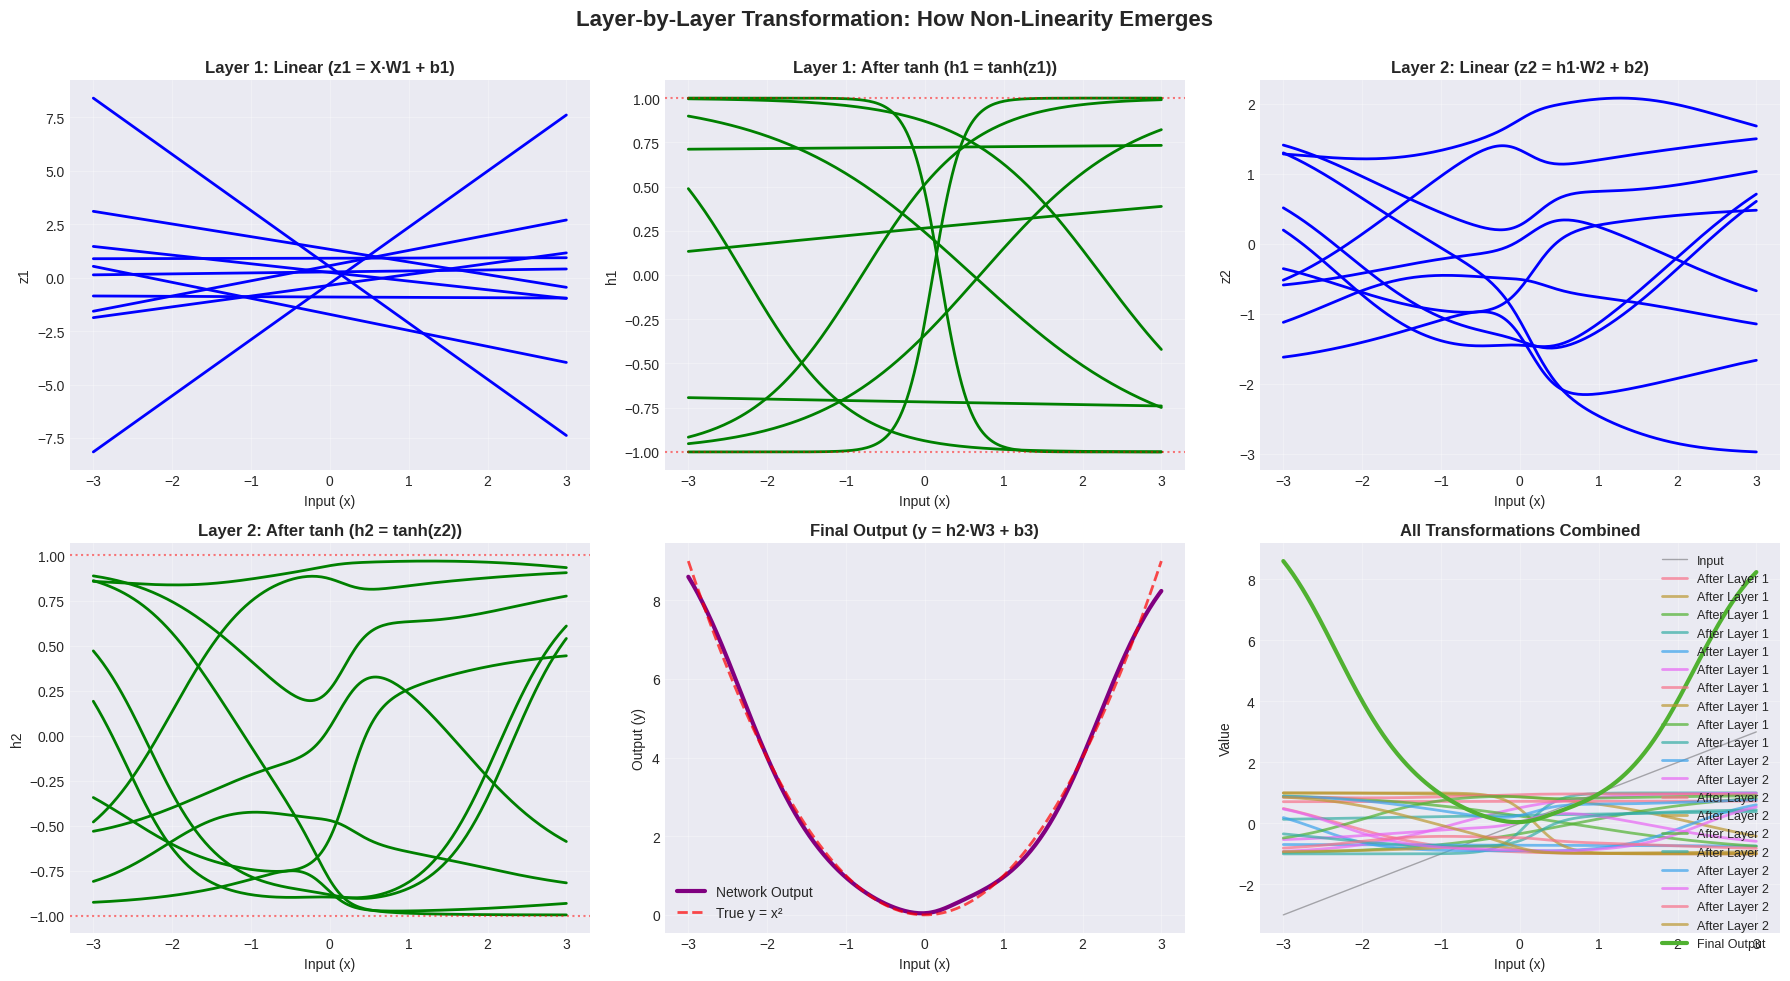


🔍 Observation:
  Each tanh activation 'warps' the signal in a non-linear way.
  The composition of these warps creates the final curved output!


In [33]:
# Get intermediate activations from non-linear network
X_demo = np.linspace(-3, 3, 200).reshape(-1, 1)

# Forward pass to get all intermediate values
z1 = X_demo @ nonlinear_net.W1 + nonlinear_net.b1
h1 = np.tanh(z1)
z2 = h1 @ nonlinear_net.W2 + nonlinear_net.b2
h2 = np.tanh(z2)
output = h2 @ nonlinear_net.W3 + nonlinear_net.b3

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Layer 1: Linear transformation
axes[0, 0].plot(X_demo, z1, 'b-', linewidth=2)
axes[0, 0].set_title('Layer 1: Linear (z1 = X·W1 + b1)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Input (x)')
axes[0, 0].set_ylabel('z1')
axes[0, 0].grid(True, alpha=0.3)

# Layer 1: After activation
axes[0, 1].plot(X_demo, h1, 'g-', linewidth=2)
axes[0, 1].axhline(y=1, color='r', linestyle=':', alpha=0.5)
axes[0, 1].axhline(y=-1, color='r', linestyle=':', alpha=0.5)
axes[0, 1].set_title('Layer 1: After tanh (h1 = tanh(z1))', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Input (x)')
axes[0, 1].set_ylabel('h1')
axes[0, 1].grid(True, alpha=0.3)

# Layer 2: Linear transformation
axes[0, 2].plot(X_demo, z2, 'b-', linewidth=2)
axes[0, 2].set_title('Layer 2: Linear (z2 = h1·W2 + b2)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Input (x)')
axes[0, 2].set_ylabel('z2')
axes[0, 2].grid(True, alpha=0.3)

# Layer 2: After activation
axes[1, 0].plot(X_demo, h2, 'g-', linewidth=2)
axes[1, 0].axhline(y=1, color='r', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=-1, color='r', linestyle=':', alpha=0.5)
axes[1, 0].set_title('Layer 2: After tanh (h2 = tanh(z2))', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Input (x)')
axes[1, 0].set_ylabel('h2')
axes[1, 0].grid(True, alpha=0.3)

# Output layer
axes[1, 1].plot(X_demo, output, 'purple', linewidth=3, label='Network Output')
axes[1, 1].plot(X_demo, X_demo**2, 'r--', linewidth=2, alpha=0.7, label='True y = x²')
axes[1, 1].set_title('Final Output (y = h2·W3 + b3)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Input (x)')
axes[1, 1].set_ylabel('Output (y)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Summary: All transformations
axes[1, 2].plot(X_demo, X_demo, 'k-', linewidth=1, alpha=0.3, label='Input')
axes[1, 2].plot(X_demo, h1, linewidth=2, alpha=0.7, label='After Layer 1')
axes[1, 2].plot(X_demo, h2, linewidth=2, alpha=0.7, label='After Layer 2')
axes[1, 2].plot(X_demo, output, linewidth=3, label='Final Output')
axes[1, 2].set_title('All Transformations Combined', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Input (x)')
axes[1, 2].set_ylabel('Value')
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Layer-by-Layer Transformation: How Non-Linearity Emerges', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('layer_by_layer_transformation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Observation:")
print("  Each tanh activation 'warps' the signal in a non-linear way.")
print("  The composition of these warps creates the final curved output!")

## 6. Mathematical Deep Dive: Taylor Series

### Why tanh Enables Non-Linearity

The Taylor series expansion of tanh around x=0:

$$\tanh(x) = x - \frac{x^3}{3} + \frac{2x^5}{15} - \frac{17x^7}{315} + ...$$

**Key insight**: The $x^3$ term introduces cubic non-linearity!

When we compose two tanh functions:
$$\tanh(W_2 \cdot \tanh(W_1 \cdot x + b_1) + b_2)$$

The nested non-linearities create even more complex patterns, including quadratic behavior.

/tmp/ipython-input-2010141129.py:23: UserWarning: Glyph 8309 (\N{SUPERSCRIPT FIVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2010141129.py:24: UserWarning: Glyph 8309 (\N{SUPERSCRIPT FIVE}) missing from font(s) Liberation Sans.
  plt.savefig('tanh_taylor_series.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8309 (\N{SUPERSCRIPT FIVE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


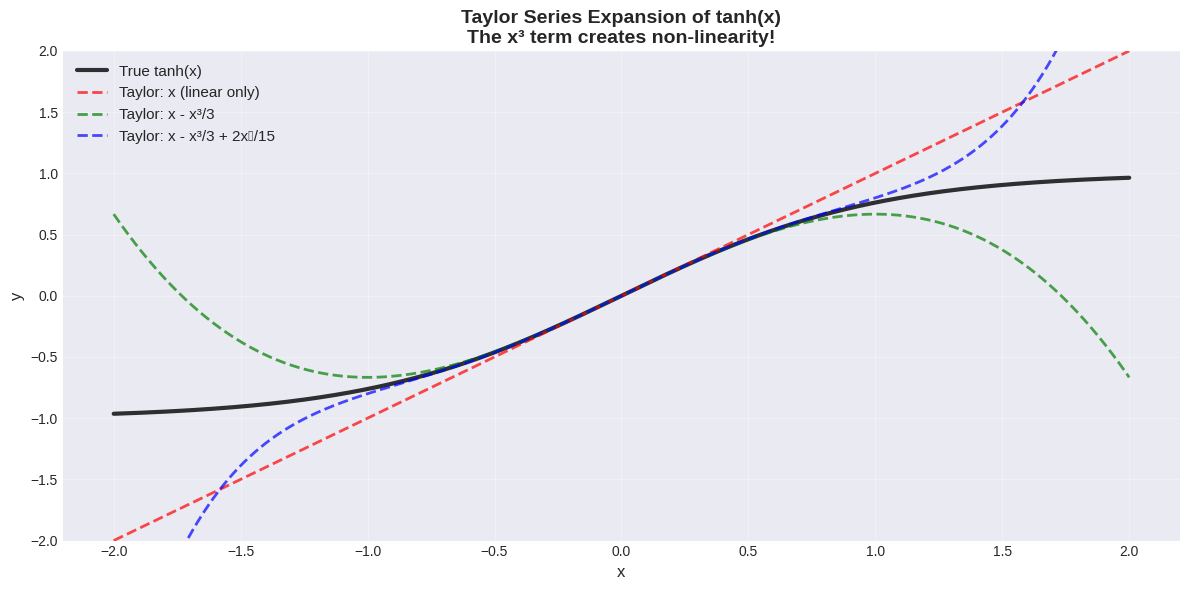


📐 Taylor Series Insight:
  Linear approximation (x): Fails to capture tanh behavior
  Cubic approximation (x - x³/3): Much better!
  The x³ term is what enables non-linear learning!


In [34]:
# Taylor series approximation of tanh
x = np.linspace(-2, 2, 1000)
tanh_true = np.tanh(x)

# Taylor series terms
taylor_1 = x  # Linear term
taylor_3 = x - x**3/3  # Up to cubic
taylor_5 = x - x**3/3 + 2*x**5/15  # Up to quintic

plt.figure(figsize=(12, 6))
plt.plot(x, tanh_true, 'k-', linewidth=3, label='True tanh(x)', alpha=0.8)
plt.plot(x, taylor_1, 'r--', linewidth=2, label='Taylor: x (linear only)', alpha=0.7)
plt.plot(x, taylor_3, 'g--', linewidth=2, label='Taylor: x - x³/3', alpha=0.7)
plt.plot(x, taylor_5, 'b--', linewidth=2, label='Taylor: x - x³/3 + 2x⁵/15', alpha=0.7)

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Taylor Series Expansion of tanh(x)\nThe x³ term creates non-linearity!', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(-2, 2)
plt.tight_layout()
plt.savefig('tanh_taylor_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📐 Taylor Series Insight:")
print("  Linear approximation (x): Fails to capture tanh behavior")
print("  Cubic approximation (x - x³/3): Much better!")
print("  The x³ term is what enables non-linear learning!")

## 7. Function Composition: The Key to Power

Let's visualize how composing tanh functions creates complexity.

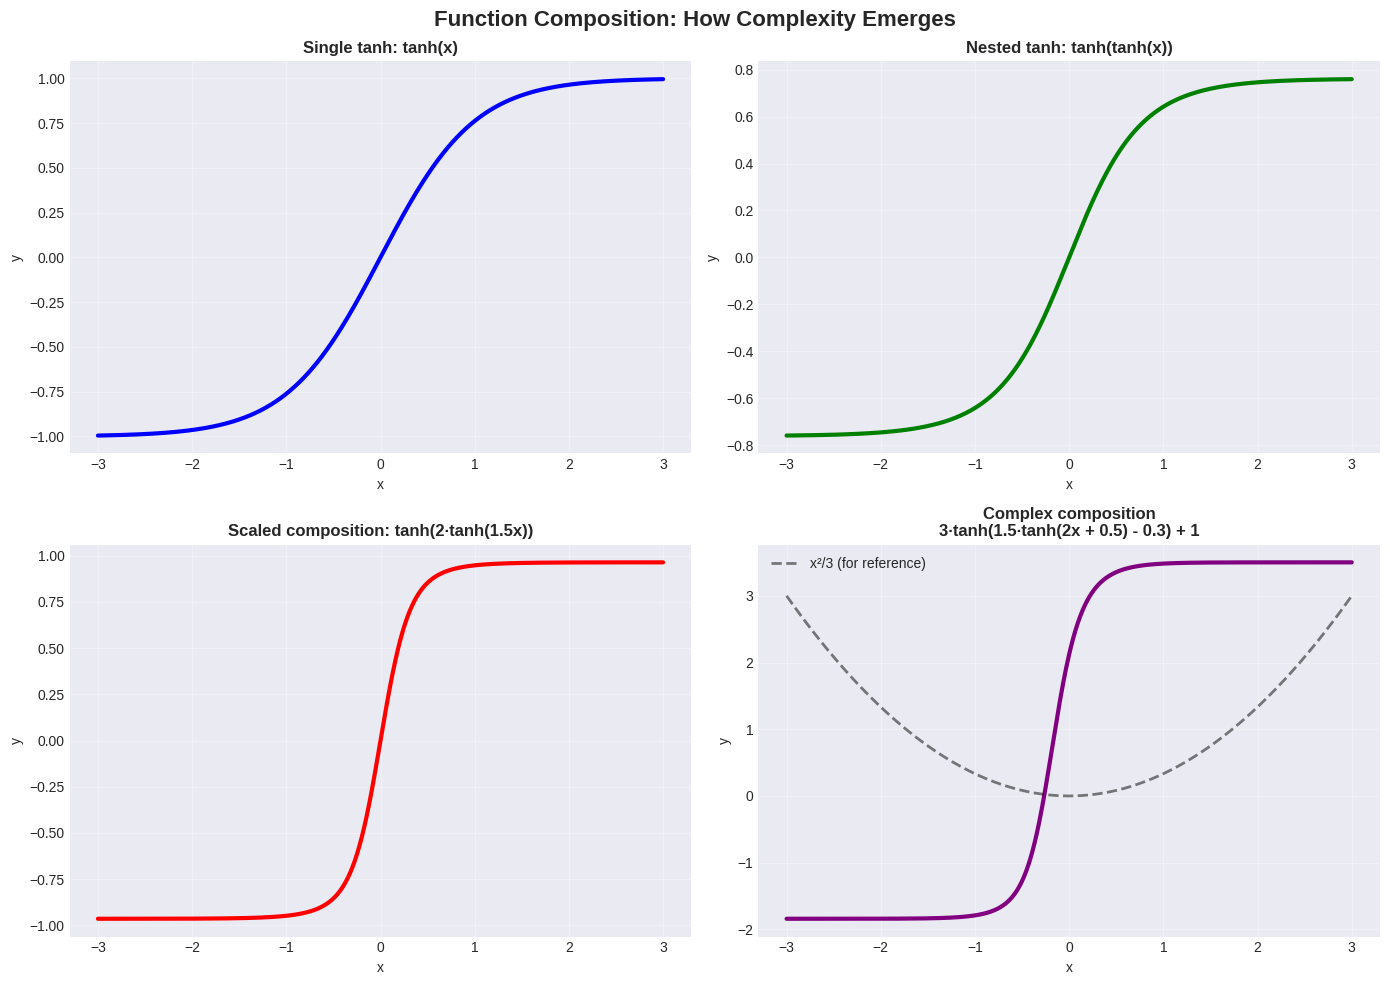


🎨 Key Insight:
  Composing non-linear functions creates increasingly complex shapes!
  With the right weights, we can approximate ANY continuous function!


In [35]:
x = np.linspace(-3, 3, 1000)

# Different compositions
y1 = np.tanh(x)
y2 = np.tanh(np.tanh(x))
y3 = np.tanh(2 * np.tanh(1.5 * x))
y4 = 3 * np.tanh(1.5 * np.tanh(2 * x + 0.5) - 0.3) + 1

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(x, y1, 'b-', linewidth=3)
axes[0, 0].set_title('Single tanh: tanh(x)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')

axes[0, 1].plot(x, y2, 'g-', linewidth=3)
axes[0, 1].set_title('Nested tanh: tanh(tanh(x))', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')

axes[1, 0].plot(x, y3, 'r-', linewidth=3)
axes[1, 0].set_title('Scaled composition: tanh(2·tanh(1.5x))', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')

axes[1, 1].plot(x, y4, 'purple', linewidth=3)
axes[1, 1].plot(x, x**2/3, 'k--', linewidth=2, alpha=0.5, label='x²/3 (for reference)')
axes[1, 1].set_title('Complex composition\n3·tanh(1.5·tanh(2x + 0.5) - 0.3) + 1', 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
axes[1, 1].legend()

plt.suptitle('Function Composition: How Complexity Emerges', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('function_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎨 Key Insight:")
print("  Composing non-linear functions creates increasingly complex shapes!")
print("  With the right weights, we can approximate ANY continuous function!")

## 8. Universal Approximation Theorem

### The Power of Neural Networks

**Universal Approximation Theorem** states:

> A neural network with:
> - At least one hidden layer
> - Non-linear activation functions  
> - Sufficient neurons
>
> Can approximate **any continuous function** to arbitrary precision!

Let's demonstrate this by approximating different functions.

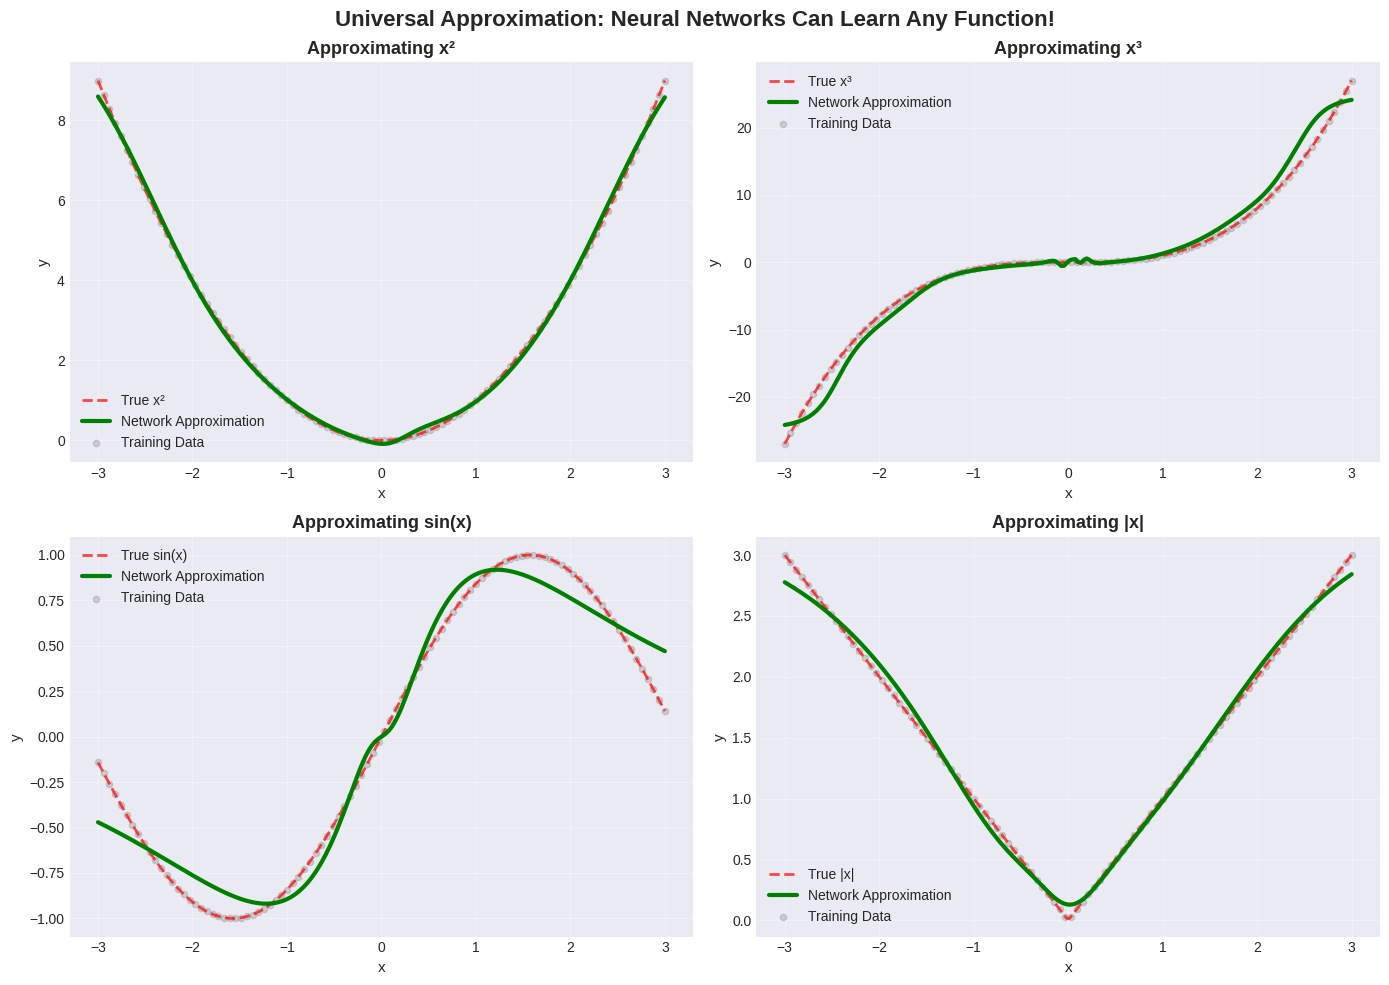


🌟 Universal Approximation Demonstrated!
  The same 2-layer architecture can approximate:
  ✅ Quadratic functions (x²)
  ✅ Cubic functions (x³)
  ✅ Trigonometric functions (sin(x))
  ✅ Piecewise functions (|x|)
  ✅ And many more!


In [37]:
# Train networks on different target functions
X_train = np.linspace(-3, 3, 100).reshape(-1, 1)

# Different target functions
functions = {
    'x²': X_train ** 2,
    'x³': X_train ** 3,
    'sin(x)': np.sin(X_train),
    '|x|': np.abs(X_train)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, y_target) in enumerate(functions.items()):
    # Train a network
    net = NonLinearNetwork(learning_rate=0.01, hidden_size=10)
    
    for epoch in range(2000):
        y_pred = net.forward(X_train)
        net.backward(y_target, y_pred)
    
    # Generate smooth predictions
    X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
    y_pred_plot = net.forward(X_plot)
    
    # Get true function values
    if name == 'x²':
        y_true_plot = X_plot ** 2
    elif name == 'x³':
        y_true_plot = X_plot ** 3
    elif name == 'sin(x)':
        y_true_plot = np.sin(X_plot)
    else:  # |x|
        y_true_plot = np.abs(X_plot)
    
    # Plot
    axes[idx].plot(X_plot, y_true_plot, 'r--', linewidth=2, label=f'True {name}', alpha=0.7)
    axes[idx].plot(X_plot, y_pred_plot, 'g-', linewidth=3, label='Network Approximation')
    axes[idx].scatter(X_train, y_target, alpha=0.3, s=20, color='gray', label='Training Data')
    axes[idx].set_title(f'Approximating {name}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('x', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Universal Approximation: Neural Networks Can Learn Any Function!', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('universal_approximation_demo.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🌟 Universal Approximation Demonstrated!")
print("  The same 2-layer architecture can approximate:")
print("  ✅ Quadratic functions (x²)")
print("  ✅ Cubic functions (x³)")
print("  ✅ Trigonometric functions (sin(x))")
print("  ✅ Piecewise functions (|x|)")
print("  ✅ And many more!")

## 9. Summary: Why Activation Functions Matter

### The Complete Picture

| Aspect | Without Activations | With Activations |
|--------|-------------------|------------------|
| **Mathematical Form** | y = X·W_combined + b | y = f(W₃·f(W₂·f(W₁·X + b₁) + b₂) + b₃) |
| **Simplification** | ✅ Collapses to linear | ❌ Cannot simplify |
| **Function Class** | Linear only | Any continuous function |
| **Can learn x²?** | ❌ No | ✅ Yes |
| **Multiple layers useful?** | ❌ No (waste) | ✅ Yes (more power) |
| **Universal Approximation?** | ❌ No | ✅ Yes |

### Key Insights

1. **Linear networks collapse**: Without activations, multiple layers = single layer
2. **Activation functions prevent collapse**: tanh, ReLU, sigmoid create non-linearity
3. **Composition is key**: Nested non-linear functions create complex patterns
4. **Taylor series explains it**: The x³ term in tanh enables non-linear learning
5. **Universal approximation**: With activations, networks can learn ANY function!

### The Answer to Your Question

**Q**: How can `((X·W1 + b1)·W2 + b2)·W3 + b3` learn x²?

**A**: It can't! But with activation functions:
```
W3·tanh(W2·tanh(W1·X + b1) + b2) + b3
```
This **cannot** be simplified to linear form, and can approximate x² (and any other function)!

The **tanh functions** are what give neural networks their power! 🚀

## 10. Practical Takeaways

### When Building Neural Networks:

1. **Always use activation functions** (except maybe the output layer)
2. **Common choices**:
   - **ReLU**: Most popular, fast, works well
   - **tanh**: Zero-centered, good for hidden layers
   - **sigmoid**: Output layer for binary classification
   - **softmax**: Output layer for multi-class classification

3. **Without activations**: You're just doing linear regression (waste of layers!)
4. **With activations**: You unlock the full power of neural networks!

### Further Exploration:

- Try different activation functions (ReLU, Leaky ReLU, ELU)
- Experiment with more layers and neurons
- Explore the Universal Approximation Theorem mathematically
- Study the vanishing gradient problem (why ReLU became popular)

---

**🎓 Congratulations!** You now understand why activation functions are essential for neural networks to learn non-linear functions like x²!